In [ ]:
# dataset load
from os.path import join
from google.colab import drive

ROOT = '/content/drive'
drive.mount(ROOT)

Mounted at /content/drive


In [ ]:
import os
import sys

MODULE_PATH = '/content/drive/MyDrive/GitHub/DL_Study/Base'

sys.path.insert(0, MODULE_PATH)
sys.path

['/content/drive/MyDrive/GitHub/DL_Study/Base',
 '',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython']

In [ ]:
# import
from config import *
from layers import Convolution, Pooling, FullyConnected
from optim import Adam

# for time series split
!pip install scikit-learn==0.24.2

     |████████████████████████████████| 22.3MB 1.8MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
# CEE for Loss
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

# ReLU activation function
class ReLU:
    def __init__(self):
        self.mask = None
    
    def forward(self, x):
        self.mask = (x<=0)
        y = x.copy()
        y[self.mask] = 0
        return y

    def backward(self, dy):
        dy[self.mask] = 0
        dx = dy
        return dx

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T
    
    x = x - np.max(x, axis=0)
    return np.exp(x) / np.sum(np.exp(x))

class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss

    def backward(self, dy=1):
        N = self.t.shape[0]
        dx = (self.y-self.t)/N
        return dx

In [ ]:
# CNN Model with Regression
class CnnModelCLF:
    def __init__(self, input_dim = (1, 24, 8), 
                 params={'filter_num':30, 'filter_size':5, 
                         'padding':0, 'stride':1},
                 hidden_size=100, output_size=2):
        filter_num = params['filter_num']
        filter_size = params['filter_size']
        padding = params['padding']
        stride = params['stride']

        # not square
        input_size = input_dim[1]
        input_size2 = input_dim[2]
        conv_output_size_h = (input_size - filter_size + 2*padding)/stride + 1
        conv_output_size_w = (input_size2 - filter_size + 2*padding)/stride + 1
        pool_output_size = int(filter_num* int(conv_output_size_h/2)* int(conv_output_size_w/2))

        self.params = {}
        rand = np.random.randn

        # He initialize
        self.params['cnn_W'] = rand(filter_num, input_dim[0], filter_size, filter_size) / np.sqrt(filter_num/2)
        self.params['cnn_b'] = np.zeros(filter_num)
        self.params['W1'] = rand(pool_output_size, hidden_size)/np.sqrt(pool_output_size/2)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = rand(hidden_size, output_size)/np.sqrt(hidden_size/2)
        self.params['b2'] = np.zeros(output_size)

        self.layers=[
                     Convolution(self.params['cnn_W'], self.params['cnn_b'], stride, padding),
                     ReLU(),
                     Pooling(pool_h=2, pool_w=2, stride=2),
                     FullyConnected(self.params['W1'], self.params['b1']),
                     ReLU(),
                     FullyConnected(self.params['W2'], self.params['b2']),
        ]
        self.loss_layer = SoftmaxWithLoss()

        self.grads = []
        self.params = []
        for i in [0, 3, 5]:
            self.params += self.layers[i].params
            self.grads+=self.layers[i].grads

    def predict(self, x):
        x = np.array(x)
        for layer in self.layers:
            x = layer.forward(x)
        x = softmax(x)
        return x

    def forward(self, x, t):
        x = np.array(x)
        t = np.array(t)
        x = self.predict(x)
        loss = self.loss_layer.forward(x, t)
        return loss

    def backward(self, dy=1):
        dy = self.loss_layer.backward(dy)

        for layer in reversed(self.layers):
            dy = layer.backward(dy)
        return dy
    
    def fit(self, train_X=None, train_y=None,learning_rate=0.01, epochs=10, batch_size=32, verbose=0):
        optimizer = Adam(learning_rate)

        data_size = train_X.shape[0]
        max_iters = data_size//batch_size

        for epoch in range(1, epochs+1):
            # shuffle train data
            idx = numpy.random.permutation(numpy.arange(data_size))
            x_data = train_X[idx]
            y_data = train_y[idx]

            epoch_loss = 0
            start_time = time.time()
            for iter in range(max_iters):
                batch_x = x_data[iter*batch_size:(iter+1)*batch_size]
                batch_y = y_data[iter*batch_size:(iter+1)*batch_size]

                loss = self.forward(batch_x, batch_y)
                self.backward()
                params, grads = self.params, self.grads
                optimizer.update(params, grads)

                epoch_loss += loss
            avg_loss = epoch_loss/max_iters

            if verbose:
                duration = start_time-time.time()
                print(f'epoch:{epoch}/{epochs}, 시간:{duration:.2f}[s], loss:{avg_loss:.5f}')

In [ ]:
# configuration setting
def model_config():
    # parameter for CNN Model
    filter_num = [30]
    filter_size = [3]
    epochs = [30]
    batch_size = [32, 64]
    learning_rate = [0.1, 0.01]
    
    # create config data
    configs = []
    for i in filter_num:
        for j in filter_size:
            for k in epochs:
                for l in batch_size:
                    for m in learning_rate:
                        config = [i, j, k, l, m]
                        configs.append(config)
    return configs

# fucntion for fit cnn model using configs
def model_fit(train_X, train_y, config):
    # unpack config
    n_filter, n_fsize, n_epochs, n_batch, learning_rate = config
    cnn_params = {'filter_num':n_filter, 'filter_size':n_fsize, 
                  'stride':1, 'padding':0}
    model = CnnModelCLF(input_dim=(1, 24, 5),params=cnn_params)
    # fit model and return
    model.fit(train_X=train_X, train_y=train_y, epochs=n_epochs, 
              batch_size=n_batch, learning_rate=learning_rate)
    return model

def metric_acc(y, t):
    y = np.array(y)
    t = np.array(t)

    y = np.argmax(y, axis=1)
    t = np.argmax(t, axis=1)
    acc = np.sum(y==t)/(float)(y.shape[0])
    return acc

In [ ]:
# dataset
import zipfile, requests, io
import pandas as pd
import numpy
import time
from datetime import datetime

data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00357/occupancy_data.zip'
r = requests.get(data_url)
with zipfile.ZipFile(io.BytesIO(r.content)) as z:
    with z.open('datatraining.txt') as f:
        df = pd.read_csv(f)
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [ ]:
df.drop(columns=df.columns[0], axis=1, inplace=True)
df.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000
mean,20.619084,25.731507,119.519375,606.546243,0.003863,0.212330
std,1.016916,5.531211,194.755805,314.320877,0.000852,0.408982
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,19.700000,20.200000,0.000000,439.000000,0.003078,0.000000
50%,20.390000,26.222500,0.000000,453.500000,0.003801,0.000000
75%,21.390000,30.533333,256.375000,638.833333,0.004352,0.000000
max,23.180000,39.117500,1546.333333,2028.500000,0.006476,1.000000


In [ ]:
df.isnull().sum()

Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64

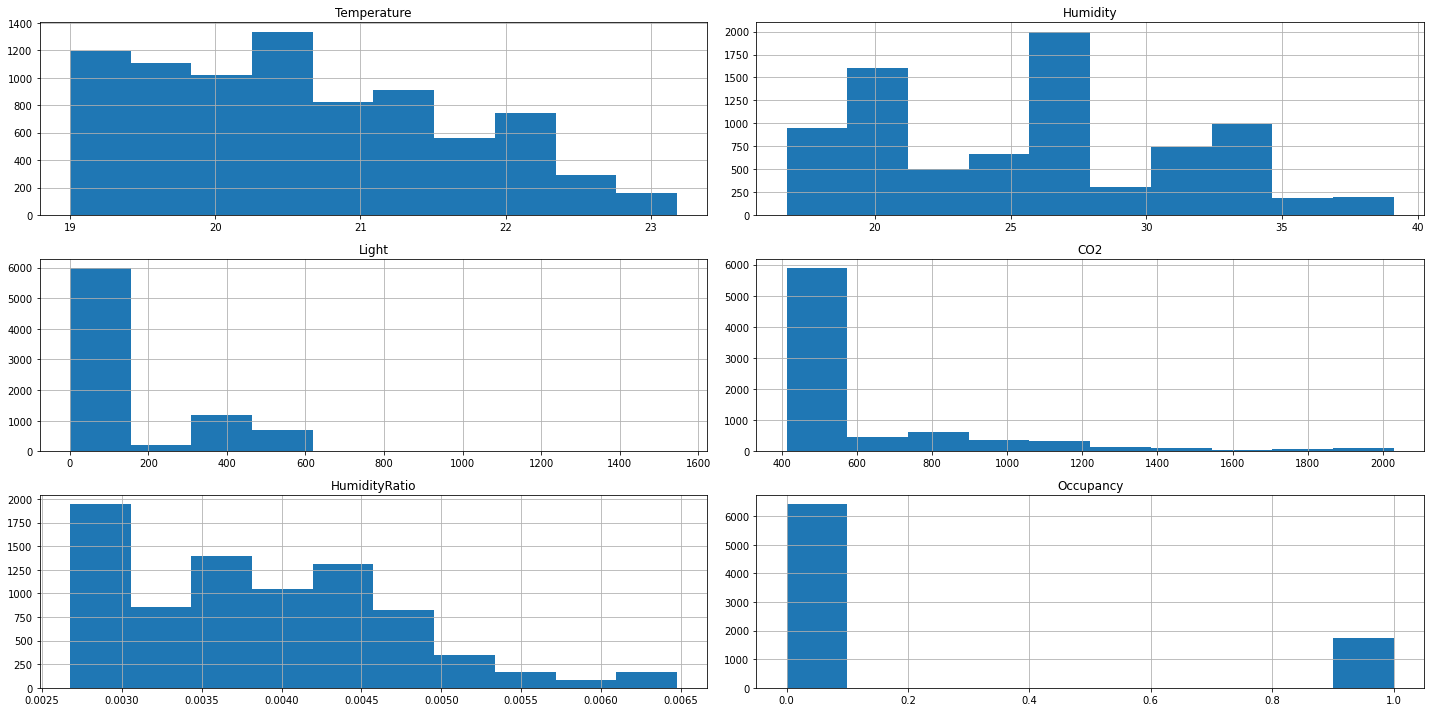

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

df.hist(figsize=(20, 10))
plt.tight_layout()
plt.show()

In [ ]:
# series data to img function
def series_to_img(dataset, time_step=1):
    num = dataset.shape[1]      # features num
    df = pd.DataFrame(dataset)
    cols, names = list(), list()
    # sequence t-n to t-1
    for i in range(time_step, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(num)]

    for i in range(0, 1):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(num)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(num)]

    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg.dropna(inplace=True)
    return agg

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

dataset = df.values
dataset = dataset.astype('float')

n_inputs = 24
n_features = 5

del_idx = n_inputs * (n_features + 1)
del_cols = [i for i in range(n_features, del_idx, n_features+1)]
del_cols += [i for i in range(del_idx-1, del_idx+n_features)]
new_df = series_to_img(dataset, n_inputs)
new_df.drop(new_df.columns[del_cols], axis=1, inplace=True)

n_splits = 3
train_test_split = TimeSeriesSplit(n_splits=n_splits+1, gap=n_inputs).split(new_df)
next(train_test_split)

configs = model_config()
history = []
best_error = []
i = 1

print('config : filter_num, filter_size, epochs, batch_size, learning_rate')

# nested cross validation for time series model
for train_cv_indices, test_cv_indices in train_test_split:
    print(f'fold : {i}/{n_splits}')
    i+=1

    # split x, y data
    train_cv_X, train_cv_y = new_df.iloc[train_cv_indices, :-1].values, new_df.iloc[train_cv_indices,-1].values
    test_cv_X, test_cv_y = new_df.iloc[test_cv_indices, :-1].values, new_df.iloc[test_cv_indices, -1].values

    # length for validation set
    test_length = len(test_cv_X)

    # scaling data
    scaler_x = MinMaxScaler()
    train_cv_X = scaler_x.fit_transform(train_cv_X)
    test_cv_X = scaler_x.transform(test_cv_X)

    onehotenc = OneHotEncoder()

    train_X, val_X = train_cv_X[:-test_length, :], train_cv_X[-test_length:, :]
    train_y, val_y = train_cv_y[:-test_length], train_cv_y[-test_length:]

    # reshape
    # inner loop
    train_X = train_X.reshape(-1, 1, n_inputs, n_features)
    val_X = val_X.reshape(-1, 1, n_inputs, n_features)
    train_y = train_y.reshape(-1, 1)
    val_y = val_y.reshape(-1, 1)
    train_y = onehotenc.fit_transform(train_y).toarray()
    val_y = onehotenc.transform(val_y).toarray()

    # outer loop
    train_cv_X = train_cv_X.reshape(-1, 1, n_inputs, n_features)
    test_cv_X = test_cv_X.reshape(-1, 1, n_inputs, n_features)
    train_cv_y = train_cv_y.reshape(-1, 1)
    test_cv_y = test_cv_y.reshape(-1, 1)
    train_cv_y = onehotenc.transform(train_cv_y).toarray()
    test_cv_y = onehotenc.transform(test_cv_y).toarray()

    # model fit, inner
    errors = []
    for idx, cfg in enumerate(configs):
        print(f' == train {cfg} model == ', end=' ')
        model = model_fit(train_X, train_y, cfg)
        predicted = model.predict(val_X)
        error = cross_entropy_error(predicted, val_y)
        print(f'error:{error.item():.6f}')
        if errors:
            if error < min(errors):
                param = idx
        else:
            param = idx
        errors.append(error)

    history.append(errors)

    # outer
    selected_model = model_fit(train_cv_X,train_cv_y, configs[param])
    predicted = selected_model.predict(test_cv_X)
    error = cross_entropy_error(predicted, test_cv_y)
    best_error.append(error)

    # model eval
    print(f'best_model => CEE : {error.item():.2f}, param:{configs[param]}')
    print()

config : filter_num, filter_size, epochs, batch_size, learning_rate
fold : 1/3
 == train [30, 3, 30, 32, 0.1] model ==  error:4.538490
 == train [30, 3, 30, 32, 0.01] model ==  error:2.164969
 == train [30, 3, 30, 64, 0.1] model ==  error:4.359731
 == train [30, 3, 30, 64, 0.01] model ==  error:0.566070
best_model => CEE : 0.12, param:[30, 3, 30, 64, 0.01]

fold : 2/3
 == train [30, 3, 30, 32, 0.1] model ==  error:-0.000000
 == train [30, 3, 30, 32, 0.01] model ==  

KeyboardInterrupt: ignored

In [ ]:
val_y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [ ]:
predicted

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [ ]:
numpy.set_printoptions(precision=6, suppress=True)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])